# Machine Learning Models and Ensemble Method
---


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

SEED = 111 # constant seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Train/Test Split:

In [2]:
df = pd.read_csv("data/UFC_TRAIN.csv")

# tackling imbalance issue
#theMin = df["Winner"].value_counts().min()
#minority = df[df["Winner"]==1].iloc[0:theMin]
#undersampleMaj = df[df["Winner"]==0].iloc[0:theMin]
#df = pd.concat([minority, undersampleMaj], axis=0)
#df["Winner"].value_counts()

# train/test split
X = df.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values
X_TRAIN, X_VAL, y_TRAIN, y_VAL = train_test_split(X,y, test_size=0.15, random_state=SEED)



#### Baseline: Always predict red (i.e: 0)

In [3]:
metrics.accuracy_score(np.zeros(len(df.index)),df["Winner"])

0.6779468544174426

Baseline accuracy is 67.96 % in unbalanced dataset

## ML Models
### 1- DNN:
Using a deep neural network with early stopping functionality to prevent divergence of loss & val_loss

In [4]:
# scaling
scaler = MinMaxScaler()
scaler.fit(X_TRAIN)
X_train = scaler.transform(X_TRAIN)
X_val = scaler.transform(X_VAL)
y_train = y_TRAIN
y_val = y_VAL
print(f"X_train shape: {X_train.shape} | X_val shape: {X_val.shape} | y_train shape: {y_train.shape} | y_val shape: {y_val.shape}")

# model
dnnClf = Sequential()

# input layer
dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))

#dnnClf.add(Dense(units=42, activation='relu'))

# output layer
dnnClf.add(Dense(units=1, activation='sigmoid'))

dnnClf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # prevent divergence of loss & val_loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

X_train shape: (3742, 42) | X_val shape: (661, 42) | y_train shape: (3742,) | y_val shape: (661,)


Train on 3742 samples, validate on 661 samples
Epoch 1/400
3742/3742 [==============================] - 3s 859us/sample - loss: 0.6605 - accuracy: 0.6283 - val_loss: 0.6352 - val_accuracy: 0.6702
Epoch 2/400
3742/3742 [==============================] - 1s 163us/sample - loss: 0.6323 - accuracy: 0.6753 - val_loss: 0.6253 - val_accuracy: 0.6702
Epoch 3/400
3742/3742 [==============================] - 1s 167us/sample - loss: 0.6322 - accuracy: 0.6793 - val_loss: 0.6231 - val_accuracy: 0.6702
Epoch 4/400
3742/3742 [==============================] - 1s 216us/sample - loss: 0.6272 - accuracy: 0.6793 - val_loss: 0.6227 - val_accuracy: 0.6702
Epoch 5/400
3742/3742 [==============================] - 1s 202us/sample - loss: 0.6291 - accuracy: 0.6793 - val_loss: 0.6234 - val_accuracy: 0.6702
Epoch 6/400
3742/3742 [==============================] - 1s 175us/sample - loss: 0.6229 - accuracy: 0.6793 - val_loss: 0.6214 - val_accuracy: 0.6702
Epoch 7/400
3742/3742 [==============================] - 1s

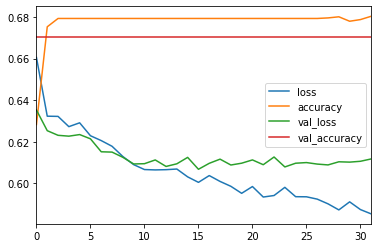

In [5]:
dnnClf.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          validation_data=(X_val, y_val), verbose=1,
          callbacks=[early_stop]
          )
model_loss = pd.DataFrame(dnnClf.history.history)
model_loss.plot()

In [6]:
dnnPreds = dnnClf.predict(scaler.transform(X_VAL))
dnnPreds = [round(i[0]) for i in dnnPreds]
dnnAcc = metrics.accuracy_score(dnnPreds, y_VAL)
print("DNN Accuracy:",round(dnnAcc,3))

DNN Accuracy: 0.67


### 2- SVM:
Using a Support Vector Machine with a linear kernel

In [7]:
svmClf = SVC(kernel="linear")
svmClf.fit(X_TRAIN,y_TRAIN)
svmPreds = svmClf.predict(X_VAL)
svmAcc = metrics.accuracy_score(svmPreds, y_VAL)
print("SVM Accuracy:",round(svmAcc,3))

# svm hp-tuning with gridSearch
#svm_param = {"kernel":("linear","poly","rbf", "sigmoid"),
#            "C":[1,52,10],
#            "degree":[3,8],
#            "gamma":("auto","scale"),
#            "coef0":[0.001,10,0.5]}
#svmClf = SVC()
#svmGrid = GridSearchCV(svmClf, svm_param,cv=2)
#svmGrid.fit(X_TRAIN, y_TRAIN)

SVM Accuracy: 0.682


### 3- RF:
Random Forest

In [8]:
rfClf = RandomForestRegressor(n_estimators = 1000, random_state = SEED)
rfClf.fit(X_TRAIN, y_TRAIN)
rfPreds = rfClf.predict(X_VAL)
rfPreds = [round(i) for i in rfPreds]
rfAcc = metrics.accuracy_score(rfPreds,y_VAL)
print("RF Accuracy:",round(rfAcc,3))

RF Accuracy: 0.679


### 4- Ensemble Method:
Ensemble method aggregates the votes of each model and gives the most frequent vote as output

In [9]:
def predictEnsemble(sample):
    print("=",end="")
    dnnPred = dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0]
    svmPred = svmClf.predict(sample.reshape(1,-1)).tolist()[0]
    rfPred = rfClf.predict(sample.reshape(1,-1)).tolist()[0]
    
    ensPred = []
    ensPred.append([dnnPred,svmPred,rfPred])
    #print(ensPred)
    ensPred = [round(i) for i in ensPred[0]]
    
    return(max(set(ensPred), key=ensPred.count)) # return mode, i.e: most frequent

ensPreds = []
[ensPreds.append(predictEnsemble(e)) for e in X_VAL]
ensAcc = metrics.accuracy_score(ensPreds,y_VAL)
print("\nEnsemble Accuracy:",round(ensAcc,3))

Ensemble Accuracy: 0.681


## Performance Evaluation:

In [10]:
print("Accuracy on unseen test dataset")
TEST = pd.read_csv("data/UFC_TEST.csv")
X_TEST = TEST.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
y_TEST = TEST["Winner"].values

dnnPreds2 = dnnClf.predict(scaler.transform(X_TEST))
dnnPreds2 = [round(i[0]) for i in dnnPreds2]
dnnAcc2 = metrics.accuracy_score(dnnPreds2, y_TEST)
print("DNN Accuracy:",round(dnnAcc2,3))

svmPreds2 = svmClf.predict(X_TEST)
svmAcc2 = metrics.accuracy_score(svmPreds2, y_TEST)
print("SVM Accuracy:",round(svmAcc2,3))

rfPreds2 = rfClf.predict(X_TEST)
rfPreds2 = [round(i) for i in rfPreds2]
rfAcc2 = metrics.accuracy_score(rfPreds2, y_TEST)
print("RF Accuracy:",round(rfAcc2,3))

ensPreds2 = []
[ensPreds2.append(predictEnsemble(e)) for e in X_TEST]
ensAcc2 = metrics.accuracy_score(ensPreds2,y_TEST)
print("\nEnsemble Accuracy:",round(ensAcc2,3))

Accuracy on unseen test dataset
DNN Accuracy: 0.677
SVM Accuracy: 0.672
RF Accuracy: 0.672
Ensemble Accuracy: 0.677


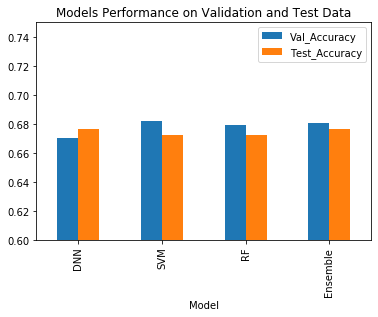

In [11]:
accTable = pd.DataFrame({"Model":["DNN","SVM","RF","Ensemble"], "Val_Accuracy":[dnnAcc,svmAcc,rfAcc,ensAcc],
                         "Test_Accuracy":[dnnAcc2,svmAcc2,rfAcc2,ensAcc2]})
accTable.plot(kind="bar",ylim=(0.6,0.75),x="Model",title="Models Performance on Validation and Test Data")

In [12]:
# save models to disk
import pickle
dnnClf.save('resources/dnn_model.h5')
pickle.dump(svmClf, open('resources/svm_model.sav', 'wb'))
pickle.dump(rfClf, open('resources/rf_model.sav', 'wb'))
pickle.dump(scaler, open('resources/scaler.pkl', 'wb'))